# Physics 494/594
## Batch Processing and Linear Algebra with Numpy

<img src='https://numpy.org/images/logos/numpy.svg' width=300px>

In [1]:
!git pull

remote: Counting objects: 29, done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 14), reused 0 (delta 0)
Unpacking objects: 100% (24/24), done.
From /lustre/haven/proj/UTK0154/local/repos/ml4s
   23c17ac..3e6d046  master     -> origin/master
Updating 23c17ac..3e6d046
Fast-forward
 data/rod_temperature.dat       |  12 ++
 src/04_Linear_Regression.ipynb | 469 +++++++++++++++++++++++++++++++++++++++++
 src/include/header.py          |   3 +-
 src/include/ml4s.py            |  21 +-
 4 files changed, 497 insertions(+), 8 deletions(-)
 create mode 100644 data/rod_temperature.dat
 create mode 100644 src/04_Linear_Regression.ipynb


In [3]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')

## Last Time

### [Notebook Link: 02_Feed_Forward_Networks.ipynb](./02_Feed_Forward_Networks.ipynb)

- Work together in groups to write code to propagate through layers
- Manually 'train' to discern features
- Visualize a neural network with 2 inputs and 1 output neurons

## Today
- Explore linear algebra in `numpy` for batch processing of samples

### `numpy` is **much** faster than built in python lists

In [4]:
%%time
num_elements = int(1E7)
x1 = []
for i in range(num_elements):
    x1.append(i*i)

CPU times: user 2.18 s, sys: 238 ms, total: 2.41 s
Wall time: 2.41 s


In [5]:
%%time
x2 = np.arange(num_elements)**2

CPU times: user 27.8 ms, sys: 34.4 ms, total: 62.1 ms
Wall time: 60.6 ms


#### Matrix Multiplication
`np.dot` contracts over the innermost index. We need to think carefully about this when considering batches of training (input) samples.

In [4]:
N = [8,7]
Nsamples = 30

W = np.random.uniform(low=-10,high=10,size=[N[1],N[0]])
x = np.zeros([N[0],Nsamples])

# Now perform the dot product (b = 0 for now)
z = np.dot(W,x)
print(z.shape)

(7, 30)


<div class="span alert alert-danger">
This is a problem! $z$ has dimensions $N_1 \times N_{\rm samples}$. Let's see what happens when we try to add the biases.
    </div>

In [8]:
b = np.random.uniform(low=-1,high=1,size=[N[1]])
z = np.dot(W,x) + b

ValueError: operands could not be broadcast together with shapes (7,30) (7,) 

We can fix this with the re-ordering if indices we discussed:

In [6]:
# But with a re-ordering of indices, this works!
# So, let's take the dimension of size 30 to be
# the very first one:
W = np.random.uniform(low=-10,high=10,size=[N[0],N[1]])
x = np.zeros([Nsamples,N[0]])

print(np.dot(x,W).shape)

NameError: name 'N' is not defined

Now we can add the bias vector and we will get the correct output shape.

In [7]:
z = np.dot(x,W)+b
print(z.shape)

NameError: name 'x' is not defined

### Modified Apply Network Functions
We need to make a small modification to our `feed_forward` function to reflect the new ordering.

`np.dot(w[ℓ],a)` $\to$ `np.dot(a,w[ℓ])`

In [15]:
def feed_forward(a0,w,b):
    num_layers = len(w)
    a = a0
    for ℓ in range(num_layers):
        z = np.dot(a,w[ℓ]) + b[ℓ]
        a = 1.0/(1.0+np.exp(-z))
    return a

Note that we have changed the code: `N[ℓ],N[ℓ-1]` to `N[ℓ-1],N[ℓ]` as $w$ is now a $N_{\ell-1} \times N_{\ell}$ matrix!

In [16]:
N = [9,5,1]
w,b = [],[]

# Note: we have updated the matrix dimensions and now start the loop at 1
for ℓ in range(1,len(N)):
    w.append(np.random.uniform(low=-10,high=10,size=(N[ℓ-1],N[ℓ])))
    b.append(np.random.uniform(low=-1,high=1, size=N[ℓ]))

Apply the network `batch_size` times in parallel!

In [17]:
%%time
batch_size=10000
x = np.random.uniform(low=-1,high=1,size=(batch_size,N[0]))
a_out = feed_forward(x,w,b)

CPU times: user 12 ms, sys: 6.47 ms, total: 18.5 ms
Wall time: 7.25 ms


Check the shape of the output

In [18]:
a_out.shape

(10000, 1)

## Efficient Visualization of our Simple Neural Network

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


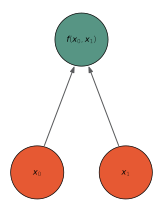

In [8]:
N = [2,1]
w,b = [],[]
for ℓ in range(len(N)-1):
    w.append(np.random.uniform(low=-10,high=10,size=(N[ℓ],N[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=N[ℓ+1]))

labels = [[r'$x_0$',r'$x_1$'],[r'$f(x_0,x_1)$']]
ml4s.draw_network(N,node_labels=labels)

### Using Meshgrid to Evaluate in Parallel

In [22]:
grid_size = 200 # the size of the grid of input values

x = np.meshgrid(np.linspace(-0.5,0.5,grid_size),np.linspace(-0.5,0.5,grid_size))

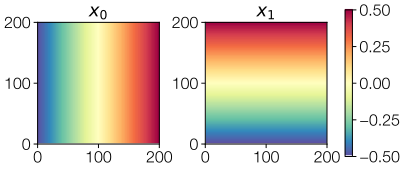

In [26]:
fig,ax = plt.subplots(1,2)
for i,cax in enumerate(ax):
    pcm = cax.pcolormesh(x[i],cmap='Spectral_r', rasterized=True)
    cax.set_title(f'$x_{i}$')
    cax.set_aspect('equal')

fig.tight_layout()
fig.colorbar(pcm, ax=ax[:], shrink=0.6);

Now we need to flatten as our network always takes a 1D array as input

In [27]:
xflat = [x[0].flatten(),x[1].flatten()]
np.shape(xflat[0]) # this should be grid_size x grid_size

(40000,)

In [28]:
batch_size = grid_size**2
a0 = np.zeros([batch_size,2])

a0[:,0]=xflat[0] # fill first component (index 0)
a0[:,1]=xflat[1] # fill second component

### Now we can apply the network for each sample in parallel

In [29]:
a1 = feed_forward(a0,w,b)

### Plot the result

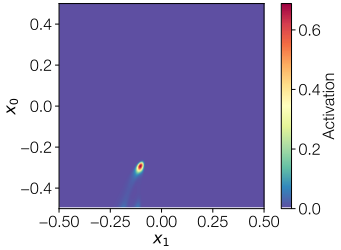

In [30]:
a1 = a1.reshape(grid_size,grid_size) # reshape for plotting

plt.imshow(a1, extent=[-0.5,0.5,-0.5,0.5], cmap='Spectral_r', rasterized=True, interpolation='lanczos', origin='lower')
plt.colorbar(label='Activation')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_0$');

### Can also visualize in 3D!

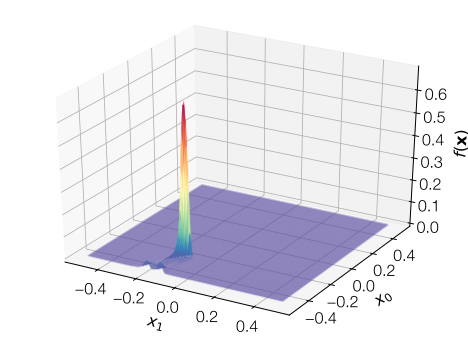

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x[0], x[1],a1 , rstride=1, cstride=1, cmap='Spectral_r', 
                       linewidth=0, antialiased=True, rasterized=True)
ax.set_xlabel(r'$x_1$',labelpad=8)
ax.set_ylabel(r'$x_0$',labelpad=8)
ax.set_zlabel(r'$f(\mathbf{x} )$',labelpad=8);